<a href="https://colab.research.google.com/github/MatiasSiles/MastercardSalesOptimization/blob/main/Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This project only search predict the Mastercard Sales using a dataset more appropriate. I don't Data Wrangling because it is innecesary in this case and i want to focus in the most important

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotly.graph_objects import Candlestick

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [20]:
df = pd.read_csv("/content/Mastercard Dataset.csv")
df["Date"] = pd.to_datetime(df["Date"])
df = df.loc[df.Date.dt.year >= 2018]
serie_sales = df[["Date", "Close"]].set_index(df["Date"]).drop("Date", axis=1)

In [57]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
2921,2018-01-02,152.009995,153.410004,151.119995,151.910004,146.521713,3168900
2922,2018-01-03,152.289993,153.979996,152.160004,153.820007,148.363953,3732400
2923,2018-01-04,154.539993,157.399994,154.320007,155.809998,150.283371,3247200
2924,2018-01-05,156.199997,159.039993,156.190002,159.039993,153.398788,2747700
2925,2018-01-08,158.580002,160.479996,158.080002,159.270004,153.862518,3143100
...,...,...,...,...,...,...,...
4544,2024-06-14,443.339996,444.959991,441.200012,444.630005,444.630005,2161500
4545,2024-06-17,442.429993,449.339996,441.679993,448.109985,448.109985,2351900
4546,2024-06-18,447.059998,451.200012,446.700012,450.109985,450.109985,2636500
4547,2024-06-20,451.059998,454.480011,448.359985,452.510010,452.510010,3006800


In [ ]:
def simple_exponential_smoothing(*, alpha, data, plot_or_data):
  start_value = data["Close"][0]
  forecast = [start_value]

  for index, value in enumerate(serie_sales["Close"]):
    calculo = forecast[index] + alpha * (value - forecast[index])
    forecast.append(calculo)

  data["Forecast"] = forecast[1:]

  me = (data["Close"] - data["Forecast"]).mean()
  mae = abs(me)

  if plot_or_data == "plot":
    plot = data.plot(figsize=(8,4))
    return plt.show()

  elif plot_or_data == "data":
    return data

df_forecast = simple_exponential_smoothing(alpha=0.2, data=serie_sales, plot_or_data="data")

In [ ]:
def forecasting_mastercad_sales_2025(*, sales):
  start_date = sales.index[-1] + pd.DateOffset(days=1)
  end_date = pd.Timestamp('2024-12-31 00:00:00')

  dates_future_sales = pd.date_range(start=start_date, end=end_date, freq='D')

  model_fit= ExponentialSmoothing(sales['Close'], trend='add', seasonal='add', seasonal_periods=365).fit()
  future_sales = model_fit.forecast(len(dates_future_sales))

  df_future_sales = pd.DataFrame({"Close": np.nan,"Forecast": list(future_sales)} , index=dates_future_sales)

  resultado_sales_prediction = pd.concat([sales, df_future_sales])
  resultado_sales_prediction_2023_2025 = resultado_sales_prediction["2023-01-01":"2025-12-31"]

  resultado_sales_prediction.plot(figsize=(15,5))
  plt.title("Mastercard Sales Forecast")
  plt.ylabel("Sales")
  plt.grid(axis="y")

  resultado_sales_prediction_2023_2025.plot(figsize=(15,5))
  plt.ylabel("Sales")
  plt.grid(axis="y")

  return plt.show()

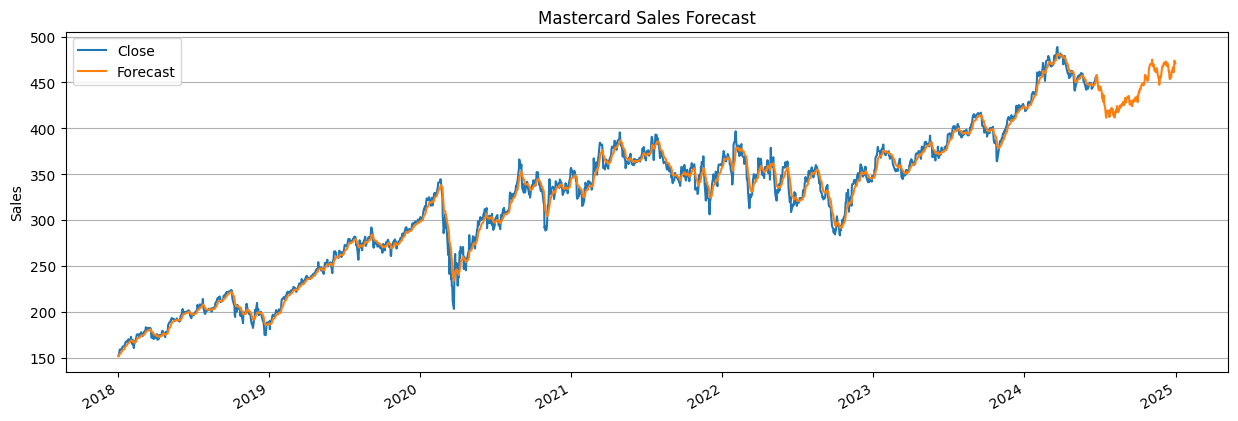

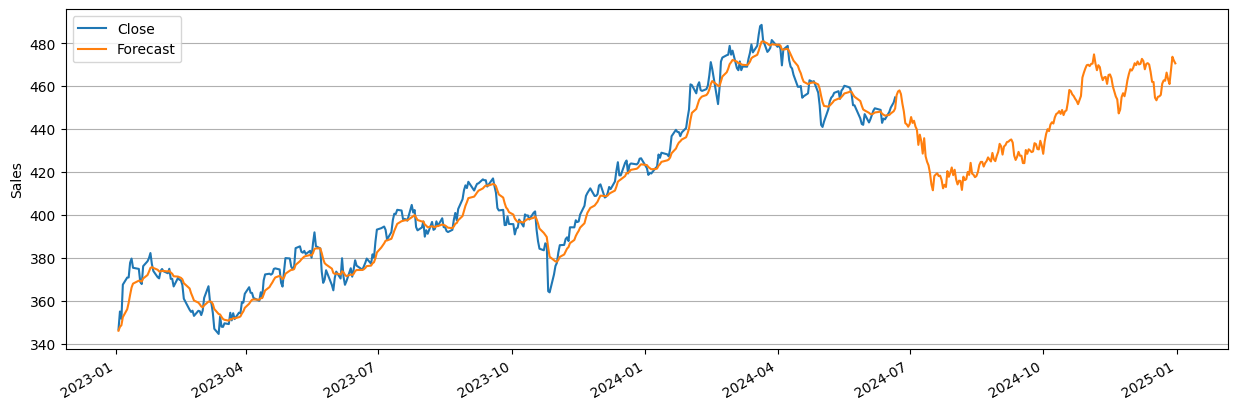

In [ ]:
forecasting_mastercad_sales_2025(sales=df_forecast)

In [ ]:
# Metrics Historic Sales
mae = mean_absolute_error(df_forecast["Close"], df_forecast["Forecast"])
mse = mean_squared_error(df_forecast["Close"], df_forecast["Forecast"])
rmse = np.sqrt(mse)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

MAE: 5.060233463625518
RMSE: 6.89448818451436


In [39]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
2921,2018-01-02,152.009995,153.410004,151.119995,151.910004,146.521713,3168900
2922,2018-01-03,152.289993,153.979996,152.160004,153.820007,148.363953,3732400
2923,2018-01-04,154.539993,157.399994,154.320007,155.809998,150.283371,3247200
2924,2018-01-05,156.199997,159.039993,156.190002,159.039993,153.398788,2747700
2925,2018-01-08,158.580002,160.479996,158.080002,159.270004,153.862518,3143100
...,...,...,...,...,...,...,...
4544,2024-06-14,443.339996,444.959991,441.200012,444.630005,444.630005,2161500
4545,2024-06-17,442.429993,449.339996,441.679993,448.109985,448.109985,2351900
4546,2024-06-18,447.059998,451.200012,446.700012,450.109985,450.109985,2636500
4547,2024-06-20,451.059998,454.480011,448.359985,452.510010,452.510010,3006800


In [99]:
class Forecasting():
  def __init__(self, *, data):
    self.data = data

  class EDA():
    def __init__(self, data):
      df = Forecasting.data

    def stadistical_summary():
      return df.select_dtypes(exclude="datetime").describe().round(2)

    def plot_stock():
      df_plot_stock = df.drop(columns={"Adj Close","Volume"}, axis=1).set_index(df["Date"]).drop("Date", axis=1)
      Candlestick(x=df_plot_stock.index, open=df_plot_stock["Open"], high=df_plot_stock["High"], low=df_plot_stock["Low"], close=df_plot_stock["Close"])

    def high_low_volatility():
      df_high_low = df[["Date", "High", "Low"]].set_index(df["Date"]).drop("Date", axis=1)
      df_high_low = df_high_low["High"] - df_high_low["Low"]
      df_high_low.plot(figsize=(15,5))
      plt.show()


Forecasting = Forecasting(data=df)

In [98]:
Forecasting.EDA.plot_stock()

AttributeError: 'Candlestick' object has no attribute 'show'